In [ ]:
#Food Processing Preservation - 2022 - Lee - Shelf‐life estimation of packaged dried foods as affected by choice of moisture

#This paper has probably the best explanation so far of the steps to arrive to the differential equation that needs to be integrated to calculate time (equation 15)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data successfully read from Drive
awi: 0.1
awc: 0.3
awe: 0.7
K: 0.9287632352872013
Y1: 8.953301084065037
tg: 0.00024107215434850067
####
aw: 0.2
K: 0.9287632352872013
Y1: 8.953301084065037
awe: 0.7
yi: 0.4153070924568261
*****
####
aw: 0.10260934714828285
K: 0.9287632352872013
Y1: 8.953301084065037
awe: 0.7
yi: 0.5807890841675983
*****
####
aw: 0.2973906528517172
K: 0.9287632352872013
Y1: 8.953301084065037
awe: 0.7
yi: 0.39052531098126686
*****
####
aw: 0.11349366333110157
K: 0.9287632352872013
Y1: 8.953301084065037
awe: 0.7
yi: 0.5490960448716531
*****
####
aw: 0.28650633666889846
K: 0.9287632352872013
Y1: 8.953301084065037
awe: 0.7
yi: 0.38926119900004535
*****
####
aw: 0.1320590431700976
K: 0.9287632352872013
Y1: 8.95330108406503

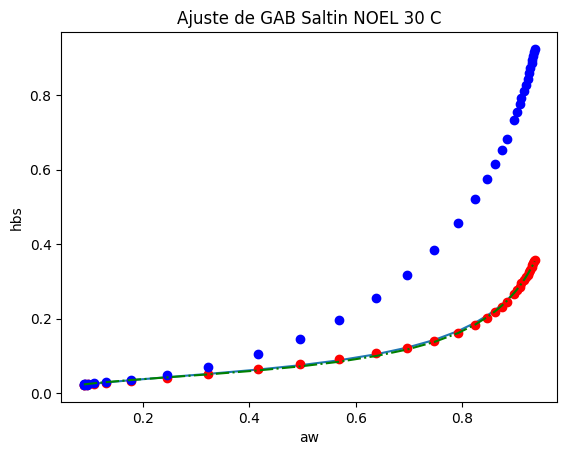

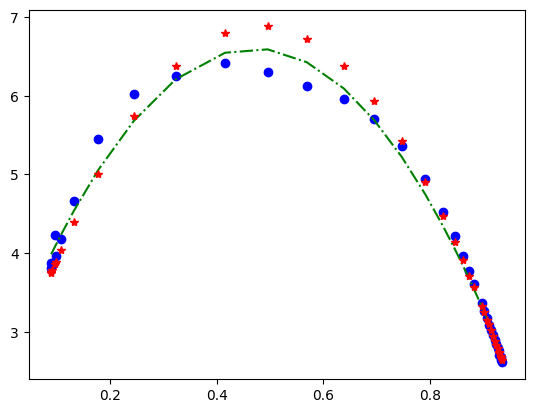

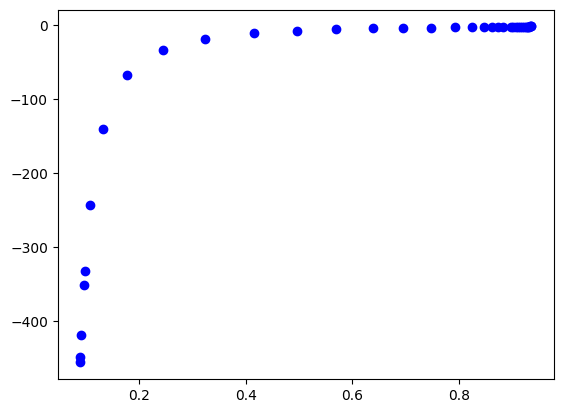

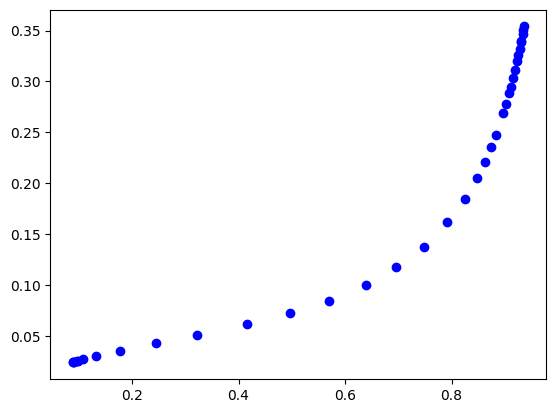

In [ ]:
#Fit awhbs Saltín NOEL 25.py

from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.optimize import leastsq, curve_fit
import numpy as np
#import math
from google.colab import drive, files
from glob import glob
import os
import warnings
import sys
import pandas as pd

# Ignore warnings
warnings.filterwarnings('ignore')
#Mount drive
drive.mount('/content/drive')
# Append local drive path to python path to allow loading local module
sys.path.append('/content/drive/MyDrive/Vida_util/')

datapath = '/content/drive/MyDrive/Vida_util/'
filename = "gab_test_data.xlsx"

def read_data(data_path, filename, sheet_name=0):
    """
    Reads data from an .xlsx file.

    Tries to read data directly from Drive. If this fails, prompts the user
    to upload the file.
    """
    try:
        # Mount drive
        drive.mount('/content/drive')
        # Read data from file
        dataframe = pd.read_excel(data_path + filename, sheet_name=sheet_name)
        print('Data successfully read from Drive')
    except Exception as e:
        print(f"Error reading from Drive: {e}")
        print('Data could not be loaded from Drive')
        print('Please upload the file')
        uploaded_filename = upload_file()  # Call the upload function
        dataframe = pd.read_excel(uploaded_filename, sheet_name=sheet_name)
        print('Data successfully uploaded')

    return dataframe


def upload_file():
    """
    Helper function to upload a file.

    This function checks for existing .xlsx files in the current
    directory and deletes them before uploading the new data file to avoid
    reading data from a previous session.
    Warning! This is intended for using in Colab, not for local use.
    The file is uploaded using colab modules
    """
    file_dir = "./"
    files_list = os.listdir(file_dir)
    for item in files_list:
        if item.endswith(".xlsx"):
            os.remove(os.path.join(file_dir, item))

    load_file = files.upload()
    filename = glob('*.xlsx')[0]
    return filename

## Función de Integración

def integrand(aw, K, Y1, awe):
    print('####')
    print(f'aw: {aw}')
    print(f'K: {K}')
    print(f'Y1: {Y1}')
    print(f'awe: {awe}')
    print(f'yi: {(1+K**2*(Y1-1)*aw**2)/((awe-aw)*(1-K*aw+Y1*K*aw)**2)}')
    print('*****')

    return (1+K**2*(Y1-1)*aw**2)/((awe-aw)*(1-K*aw+Y1*K*aw)**2)

def fit_sim(x,awex,awhbs):
    '''
    GAB equation in the form:
    aw/w = a + b*aw + c*aw^2
    the return statement is for the objective function, i.e
    0 = aw/w - a + b*aw + c*aw^2
    awhbs = aw/w
    DOI: 10.1007/s11947-007-0012-3
    '''
    a=x[0]  ##B
    b=x[1] ##C
    c=x[2] ##L

    #tio=np.linspace(0,120,50)
    return (awhbs-(a*awex**2+b*awex+c))


def fit_sim2(x,awex,awhbs):
    '''
    GAB equation in the form:
    aw/w = a + b*aw + c*aw^2
    the return statement is for the objective function, i.e
    0 = aw/w - a + b*aw + c*aw^2
    awhbs = aw/w
    DOI: 10.1007/s11947-007-0012-3
    '''
    a=x[2]  ##B
    b=x[1] ##C
    c=x[0] ##L

    #tio=np.linspace(0,120,50)
    return (awhbs-(a*awex**2+b*awex+c))


def GAB_fit(x,awex,hbs):
    '''
    GAB equation in the form:
    w = w_m*K*C/(1-K*aw)*(1-K*aw+K*C*aw)
    the return statement is for the objective function, i.e
    0 = w - w_m*K*C/(1-K*aw)*(1-K*aw+K*C*aw))

    DOI: 10.1007/s11947-007-0012-3
    '''
    m0=x[0]  ##B
    k=x[1] ##C
    C=x[2] ##L

    #tio=np.linspace(0,120,50)
    return (hbs-(m0*k*C)/((1-k*awex)*(1-k*awex+k*C*awex)))
    #return ((m0*k*C)/((1-k*awex)*(1-k*awex+k*C*awex)))


def GAB_equation(awex, w_m, k, C):
    '''
    GAB equation in the form:
    w = w_m*K*C/(1-K*aw)*(1-K*aw+K*C*aw)

    The arguments are defined in an order suitable for scipy.optimize.curve_fit
    i.e, first arg is the independent variable, the rest of the arguments are
    the parameters

    DOI: 10.1007/s11947-007-0012-3
    '''

    return ((w_m*k*C*awex)/((1-k*awex)*(1-k*awex+k*C*awex)))


def ratio(awex, a, b, c):
    return (a + b*awex + c*awex**2)


def polynomial(x, args):
    if len(args) == 1:
        return args[0]
    elif len(args) == 2:
        return args[0] + args[1]*x
    elif len(args) == 3:
        return args[0] + args[1]*x + args[2]*x**2
    # continue with elif statements for higher degree...
    # This is not practical!





## Ingreso De Isotermas De Sorción Provenientes del VSA

aw_data = read_data(datapath, filename)


## Vector de Actividad Acuosa

awex = aw_data['aw'].values

## Vector de Humedad En Base Seca
hbs = aw_data['moisture'].values


## Ajuste de Parámetros para Isoterma de GAB
awhbs=awex/hbs

xcero = [1.0, 1.0, 1.0]

## FUnción de Optimización de parámetros ára ajuste de GAB

x,c,info,msg,success=leastsq(fit_sim,xcero,args=(awex,awhbs),full_output=1)

awhbs_new=x[0]*awex**2+x[1]*awex+x[2]
hbs_new=awex/awhbs_new
#awhbs_new=x[2]*awex**2+x[1]*awex+x[0]
#hbs_new=awex/awhbs_new

## Constantes de GAB

#WHERE DOES THIS COME FROM
# THIS SEEMS TO BE RELATED TO THE CALCULATION OF GAB PARAMETERS FROM THE POLYNOMIAL
# COEFFICIENTS OF THE FORM OF THE EQUATION aw/w = a + b*aw + c*aw^2
# HOWVWER IT DOES NOT CORRESPOND EXACTLY TO THAT
Mgm=np.sqrt(1/((x[1]**2)-4*x[0]*x[2]))
K=-1*((2*x[0]*Mgm)/(x[1]*Mgm+1))
Y1=1/(Mgm*x[2]*K)


## Constantes Ecuación Antoinne para Presión de Vapor en Función de T aplican entre 0 y 100 °C
A1=8.07131
B1=1730.63
C1=233.426

#Datos de Entrada Adicionales a la isoterma de sorciónn (Ingresa Usuario)

awi=0.1 # Actividad Acuosa Inicial del Producto
awc=0.3 # Actividad Acuosa Crítica
awe=0.7 #Humedad Relativa de almacenamiento expresado como proporciónj (%HR/100)
T=37.8 # Temperatura del Ensayo de WVTR usualmente es la misma en °C
Ta=25 # Temperatura de Almacenamiento del Producto en °C
WVTR=0.3 ## Velocidad de Transmisión de Vapor de Agua en g/m^2*día. Lo determina el ICIPC (Eafit)
A=0.1143 ## Area empacada expuesta, corresponde con el área geompetrica de la unidad de venta en m^2
W= 300 ## Peso neto empacado en g


## Cálculos relacionados y Solución de Ecuación Diferencial

Po=10**(A1-(B1/(C1+T)))*(101325/760) #Presión de Vapor de Agua en el a T °C
P=10**(A1-(B1/(C1+Ta)))*(101325/760) #Presión de Vapor del agua a Ta °C
dhr=awe-awi ## Delta de humedad
B=WVTR/(Po*dhr) # Permabilidad del material de empaque

tg=(B*A*P)/(Mgm*Y1*K*W) # Lado derecho ecuación diferencial
print(f'awi: {awi}')
print(f'awc: {awc}')
print(f'awe: {awe}')
print(f'K: {K}')
print(f'Y1: {Y1}')
print(f'tg: {tg}')
y = quad(integrand, awi, awc, args= (K, Y1,awe) ) ## Solución lado izquierdo ecuación diferencial
t=y[0]/tg # tiempo de vida útil en días
print(f'y: {y}')
print(f't: {t}')
## Impresión de Mensaje con el resultado de predicción en días

cadena= "El tiempo de Vida Útil para su producto" + " almacenado a " + str(Ta) + " °C" + " y " + str(awe*100) +" %" " es: " + str(round(t,2)) + " dias"
print(cadena)


popt, pcov = curve_fit(GAB_equation, awex, hbs)

popt2, pcov2 = curve_fit(ratio, awex, awex/hbs)
# compare the results from curve fitting to parameters calculated from GAB_equation
#GAB_equation(awex, w_m, k, C)
a1 = 1/(popt[0]*popt[1]*popt[2])
b1 = (popt[2]-2)/(popt[0]*popt[2])
c1 = popt[1]*(1-popt[2])/(popt[0]*popt[2])

print('Max')
print((popt[2]-2)/(2*popt[1]*(popt[2]-1)))

## Gráficos relacionados

#plt.plot(awex,hbs_new,awex,hbs,'o')
plt.plot(awex,hbs_new) #Calculado
plt.plot(awex,hbs,'or') #real
plt.plot(awex,hbs - awex/GAB_fit(x,awex,hbs),'ob') #GAB_fit
plt.plot(awex,GAB_equation(awex,popt[0], popt[1], popt[2]),'-.g')
#plt.plot(awex,awex/GAB_curve(x,awex,hbs),'og') #GAB_fit
plt.title('Ajuste de GAB Saltin NOEL 30 C')
plt.ylabel('hbs')
plt.xlabel('aw')
plt.show()

plt.plot(awex,awex/hbs,'ob') #real
plt.plot(awex,ratio(awex,popt2[0], popt2[1], popt2[2]),'-.g')
plt.plot(awex,ratio(awex,a1,b1,c1),'*r')
plt.show()

plt.plot(awex,GAB_fit(x,awex,hbs),'ob') #GAB_fit
plt.show()

plt.plot(awex,GAB_equation(awex,popt[0], popt[1], popt[2]),'ob')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data successfully read from Drive
--- Testing Polynomial Fits ---

Fitting polynomial of degree 2...
  Coefficients: [  2.62   16.92  -17.974]
  R-squared: 0.9853

Fitting polynomial of degree 3...
  Coefficients: [  2.606  17.074 -18.338   0.231]
  R-squared: 0.9853

Fitting polynomial of degree 4...
  Coefficients: [  1.221  37.533 -99.198 116.927 -55.688]
  R-squared: 0.9979

Fitting polynomial of degree 5...
  Coefficients: [   0.736   46.291 -148.714  234.359 -178.603   46.959]
  R-squared: 0.9983
[{'degree': 2, 'popt': array([  2.61996465,  16.91965413, -17.97433722]), 'pcov': array([[ 0.0075756 , -0.03477543,  0.02953817],
       [-0.03477543,  0.22220166, -0.20673135],
       [ 0.02953817, -0.20673135,  0.19777248]]), 'r_squared': np.float64(0.9852589054110586)}, {'degree': 3, 'popt': array([  2.60635507,  17.07423641, -18.33782163,   0.23134388]), 'p

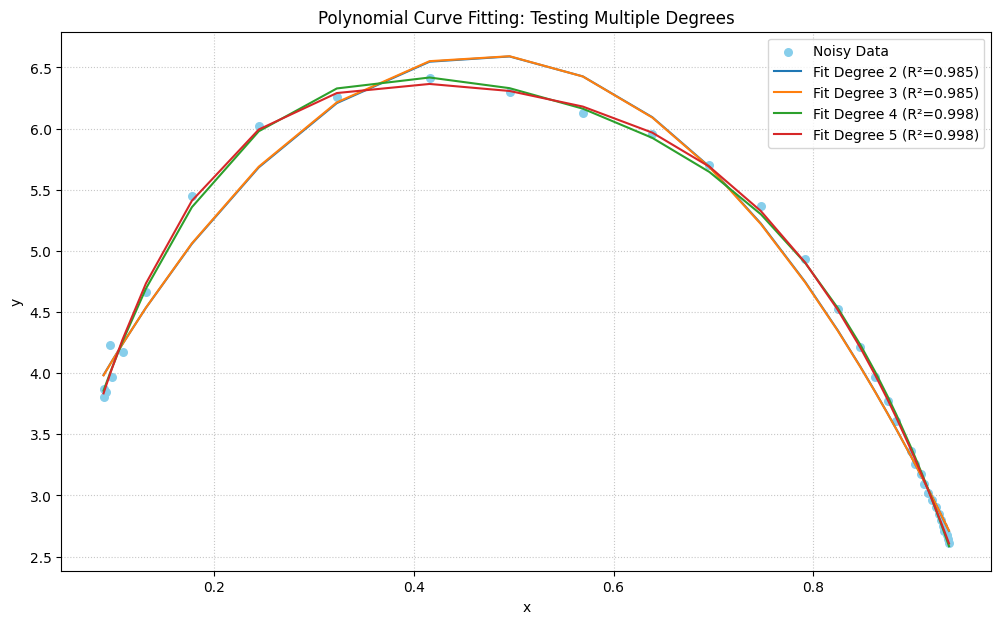

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# (Polynomial model function from above)
def polynomial_model(x, *coeffs):
    y_value = 0
    for i, coeff in enumerate(coeffs):
        y_value += coeff * (x**i)
    return y_value


aw_data = read_data(datapath, filename)
## Vector de Actividad Acuosa
x_data = aw_data['aw'].values

## Vector de Humedad En Base Seca
y_data = aw_data['moisture'].values

y_data = x_data/y_data

# --- Generate some sample data ---
# Let's create data that roughly follows a 2nd degree polynomial: y = 1 + 2x + 0.5x^2
#np.random.seed(42) # for reproducibility
#x_data = np.linspace(-10, 10, 100)
#true_coeffs = [1, 2, 0.5] # c0, c1, c2
#y_true = polynomial_model(x_data, *true_coeffs)
#y_data = y_true + 5 * np.random.normal(size=len(x_data)) # Add some noise

# --- Test curve fitting for multiple degrees ---
max_degree_to_test = 5
fitted_results = []

print("--- Testing Polynomial Fits ---")
for degree in range(2, max_degree_to_test + 1):
    num_coeffs = degree + 1

    # Provide initial guesses for the coefficients. The length of p0
    # tells curve_fit how many parameters to fit.
    initial_guesses = np.ones(num_coeffs)

    print(f"\nFitting polynomial of degree {degree}...")
    try:
        # Perform the curve fit
        popt, pcov = curve_fit(polynomial_model, x_data, y_data, p0=initial_guesses)

        # Calculate y_fit and R-squared for goodness of fit
        y_fit = polynomial_model(x_data, *popt)
        residuals = y_data - y_fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_data - np.mean(y_data))**2)
        r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 1.0

        fitted_results.append({
            'degree': degree,
            'popt': popt, # optimized parameters
            'pcov': pcov, # covariance matrix
            'r_squared': r_squared
        })
        print(f"  Coefficients: {np.round(popt, 3)}")
        print(f"  R-squared: {r_squared:.4f}")

    except RuntimeError:
        print(f"  Could not fit polynomial of degree {degree}. This often happens if the model is too complex for the data or initial guesses are poor.")
    except Exception as e:
        print(f"  An unexpected error occurred for degree {degree}: {e}")

print(fitted_results)

# --- Determine and display the best fit (e.g., highest R-squared) ---
if fitted_results:
    # Sort by R-squared in descending order (higher is better)
    # You might also consider other metrics like AIC or BIC for model selection
    best_fit = sorted(fitted_results, key=lambda item: item['r_squared'], reverse=True)[0]
    print("\n--- Best Fit (based on R-squared) ---")
    print(f"Degree: {best_fit['degree']}")
    print(f"Coefficients: {np.round(best_fit['popt'], 3)}")
    print(f"R-squared: {best_fit['r_squared']:.4f}")

    # --- Plotting the results ---
    plt.figure(figsize=(12, 7))
    plt.scatter(x_data, y_data, label='Noisy Data', color='skyblue', s=30, zorder=1)
    #plt.plot(x_data, y_true, label='True Underlying Function (Degree 2)', color='black', linestyle='--', linewidth=2, zorder=2)

    # Plot a few of the fitted curves
    for result in fitted_results:
        #if result['degree'] == best_fit['degree'] or result['degree'] <= 2: # Plot best and some lower degrees for comparison
        y_plot = polynomial_model(x_data, *result['popt'])
        plt.plot(x_data, y_plot, label=f'Fit Degree {result["degree"]} (R²={result["r_squared"]:.3f})', linewidth=1.5, zorder = 3 if result['degree'] == best_fit['degree'] else 2)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Polynomial Curve Fitting: Testing Multiple Degrees')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()
else:
    print("\nNo successful fits were made.")

In [ ]:
# (Assuming polynomial_model, x_data, y_data, fitted_results, and best_fit
#  are available from the execution of the previous script parts)

# Example placeholder for best_fit and x_data if running this part standalone.
# In a full script, these would be determined by the preceding fitting process.
# if 'best_fit' not in locals(): # Mock data for standalone testing
#     print("Mocking best_fit for demonstration...")
#     # E.g., a 2nd degree polynomial: y = 1 + 3x - 0.5x^2. Max at x=3.
#     best_fit = {'degree': 2, 'popt': np.array([1.0, 3.0, -0.5])}
#     x_data = np.linspace(-2, 8, 100) # Ensure x=3 is in range
#     def polynomial_model(x, *coeffs):
#         y_value = 0
#         for i, coeff in enumerate(coeffs):
#             y_value += coeff * (x**i)
#         return y_value


if 'best_fit' in locals() and best_fit and best_fit['popt'] is not None:
    coeffs_best = best_fit['popt']
    degree_best = best_fit['degree']

    print(f"\n--- Analyzing Best Fit (Degree {degree_best}) for Local Maximum ---")

    # A local maximum (where P'(x)=0) typically requires degree >= 2.
    # For degree 0 (constant) or 1 (linear), extrema are at the boundaries of a defined interval.
    if degree_best < 2:
        print(f"  The best fit is a polynomial of degree {degree_best}.")
        print("  A local maximum (where derivative is zero and changes sign) generally requires a degree of 2 or higher.")

        # Check boundary values for linear/constant cases as they might be the max over the interval
        y_at_boundaries = polynomial_model(np.array([x_data[0], x_data[-1]]), *coeffs_best)
        if degree_best == 1: # Linear
            if coeffs_best[1] > 0: # Positive slope
                print(f"  Linear function with positive slope: maximum on the interval [{x_data[0]:.2f}, {x_data[-1]:.2f}] is at x = {x_data[-1]:.2f}, y = {y_at_boundaries[1]:.2f}.")
            elif coeffs_best[1] < 0: # Negative slope
                print(f"  Linear function with negative slope: maximum on the interval [{x_data[0]:.2f}, {x_data[-1]:.2f}] is at x = {x_data[0]:.2f}, y = {y_at_boundaries[0]:.2f}.")
            else: # Zero slope (effectively constant)
                print(f"  The function is effectively constant: y = {coeffs_best[0]:.2f}.")
        else: # Degree 0 (constant)
            print(f"  The function is constant: y = {coeffs_best[0]:.2f}.")

    else: # Degree 2 or higher, can have true local maxima
        # np.polyder and np.polyval expect coefficients in decreasing order of power: [cn, ..., c1, c0]
        # Our 'coeffs_best' is [c0, c1, ..., cn]
        p_coeffs_numpy_order = np.array(coeffs_best)[::-1]

        # First derivative coefficients: P'(x)
        # np.polyder returns coefficients in the same (decreasing power) order
        p_prime_coeffs = np.polyder(p_coeffs_numpy_order, 1)

        # Second derivative coefficients: P''(x)
        p_double_prime_coeffs = np.polyder(p_coeffs_numpy_order, 2)

        # Find roots of the first derivative (x-values of critical points)
        critical_points_x_candidates = np.roots(p_prime_coeffs)

        potential_maxima_info = []
        x_data_min, x_data_max = np.min(x_data), np.max(x_data)

        if critical_points_x_candidates.size > 0:
            print(f"  Critical point candidates (x where P'(x)=0): {np.round(critical_points_x_candidates, 3)}")
            for cp_x_val in critical_points_x_candidates:
                if np.isreal(cp_x_val): # Consider only real roots
                    cp_x = np.real(cp_x_val)

                    # Evaluate second derivative at this critical point
                    # np.polyval expects coefficients in decreasing power order
                    val_second_derivative = np.polyval(p_double_prime_coeffs, cp_x)

                    # Check for local maximum condition (P''(x) < 0)
                    # Using a small epsilon to avoid issues with floating point numbers near zero
                    if val_second_derivative < -1e-7:
                        # Calculate the y-value of the potential maximum
                        # polynomial_model expects coeffs as [c0, c1, ...]
                        y_at_cp = polynomial_model(cp_x, *coeffs_best)

                        is_within_data_range = (cp_x >= x_data_min) and (cp_x <= x_data_max)

                        potential_maxima_info.append({
                            'x': cp_x,
                            'y': y_at_cp,
                            'd2y_dx2': val_second_derivative,
                            'in_range': is_within_data_range
                        })
                        status_msg = "in data range" if is_within_data_range else "out of data range"
                        print(f"    Found potential local maximum ({status_msg}): x={cp_x:.3f}, y={y_at_cp:.3f}, P''(x)={val_second_derivative:.3f}")

            if potential_maxima_info:
                # Filter for maxima within the x_data range
                in_range_maxima = [m for m in potential_maxima_info if m['in_range']]

                if in_range_maxima:
                    # Select the one with the highest y-value among those in range
                    identified_local_max = max(in_range_maxima, key=lambda m: m['y'])
                    print(f"\n  --> Identified Local Maximum (highest within data range):")
                    print(f"      Location: x = {identified_local_max['x']:.4f}")
                    print(f"      Value:    y = {identified_local_max['y']:.4f}")

                    # Store it for plotting (optional, depends on your script structure)
                    best_fit['local_maximum'] = identified_local_max

                else: # No local maxima were found within the defined x_data range
                    print("\n  No local maxima (P'(x)=0, P''(x)<0) found within the x_data range.")
                    out_of_range_maxima = [m for m in potential_maxima_info if not m['in_range']]
                    if out_of_range_maxima:
                         print("    (However, potential local maxima were identified outside the x_data range.)")
            else: # No critical points satisfied the P''(x) < 0 condition
                print("\n  No points satisfied the conditions for a local maximum (P'(x)=0 and P''(x)<0).")
        else: # The first derivative polynomial has no roots (e.g., if P'(x) is a non-zero constant)
            print("\n  No critical points found (the derivative P'(x) has no roots). This is unexpected for degree >= 2 polynomials.")

    # --- Example of how to integrate this into your plotting ---
    # (This assumes 'plt' from matplotlib.pyplot is imported and you have a plot of your data and best_fit curve)
    # if 'plt' in locals() and best_fit.get('local_maximum'):
    #     max_info = best_fit['local_maximum']
    #     plt.scatter([max_info['x']], [max_info['y']],
    #                 color='red', marker='X', s=150, zorder=5,
    #                 label=f"Identified Max (x={max_info['x']:.2f})")
    #     plt.legend() # Ensure legend is updated
    #     # plt.show() # Or call this at the very end of all plotting

else:
    print("Best fit model (best_fit) not available or not determined. Cannot find local maximum.")


--- Analyzing Best Fit (Degree 5) for Local Maximum ---
  Critical point candidates (x where P'(x)=0): [1.648+0.j    0.494+0.224j 0.494-0.224j 0.406+0.j   ]
    Found potential local maximum (in data range): x=0.406, y=6.366, P''(x)=-16.988

  --> Identified Local Maximum (highest within data range):
      Location: x = 0.4058
      Value:    y = 6.3662


[2.12448107 0.93551569 0.00533417]
49.03912013623108
0.009074387932813363
0.04425227889192978
(3.0103830349359972, 3.1496504754593454e-10)
68.02775157156925
272.111006286277
El tiempo de Vida Útil para su producto almacenado a 30 °C y 70.0 % es: 68.02775157156925 dias


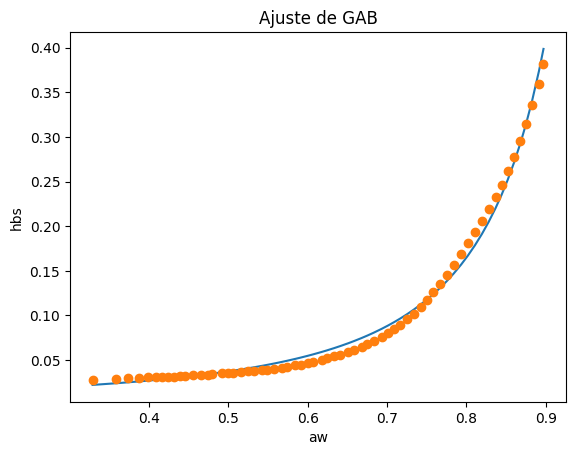

In [ ]:
#TVU Snack Queso y Albahaca 30.py
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 27 14:05:44 2016

@author: GNjabuiles
"""

"""
Created on Wed Jan 20 08:57:18 2016

@author: GNjabuiles
"""


from scipy.integrate import quad



## Definiendo Parámetros
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import numpy as np
#import math


awex=np.array([0.3289,
0.3586,
0.3739,
0.3876,
0.3987,
0.4082,
0.417,
0.424,
0.4319,
0.4394,
0.4456,
0.4559,
0.4655,
0.4737,
0.4797,
0.4916,
0.5,
0.5057,
0.5153,
0.5251,
0.5328,
0.5426,
0.5488,
0.558,
0.5672,
0.5736,
0.5844,
0.591,
0.6003,
0.6066,
0.6177,
0.6239,
0.6332,
0.6412,
0.6508,
0.6581,
0.6678,
0.6752,
0.683,
0.6932,
0.7012,
0.7089,
0.7168,
0.7255,
0.7334,
0.7423,
0.7497,
0.7584,
0.7666,
0.775,
0.7838,
0.7933,
0.8018,
0.8107,
0.8194,
0.828,
0.8366,
0.8443,
0.8519,
0.8602,
0.8677,
0.8747,
0.8823,
0.8913,
0.897])



## Vector de Humedad En Base Seca

hbs=np.array([0.0276,
0.0289,
0.0293,
0.0298,
0.0304,
0.0313,
0.0311,
0.0313,
0.0315,
0.032,
0.0319,
0.033,
0.0337,
0.0337,
0.0341,
0.0349,
0.0357,
0.0356,
0.0366,
0.0372,
0.0376,
0.0389,
0.0393,
0.0399,
0.0411,
0.0426,
0.0441,
0.0449,
0.0466,
0.0479,
0.05,
0.0518,
0.0541,
0.056,
0.0587,
0.0612,
0.0647,
0.0681,
0.0714,
0.0759,
0.0801,
0.0846,
0.0895,
0.0959,
0.1021,
0.1095,
0.1172,
0.1259,
0.1355,
0.1456,
0.1569,
0.1684,
0.1806,
0.193,
0.2059,
0.2189,
0.2326,
0.2467,
0.2617,
0.278,
0.2955,
0.3145,
0.3358,
0.3598,
0.3816])

# No mover


def fit_sim(x,awex,hbs):
    m0=x[0]  ##B
    k=x[1] ##C
    C=x[2] ##L

    #tio=np.linspace(0,120,50)
    return (hbs-(m0*k*C)/((1-k*awex)*(1-k*awex+k*C*awex)))


xcero = [1.0,1.0,1.0]



#ti1=np.linspace(0,100,50)

x,c,info,msg,success=leastsq(fit_sim,xcero,args=(awex,hbs),full_output=1)
hbs_new=(x[0]*x[1]*x[2])/((1-x[1]*awex)*(1-x[1]*awex+x[1]*x[2]*awex))
#Vt_new1=x[0]*(1-np.exp(-x[1]*(ti-x[2])-x[3]*(np.sqrt(ti)-np.sqrt(x[2]))))
#Vt=2*(1-math.exp(-3*(ti1-4)-1.5*(math.sqrt(ti1)-math.sqrt(4))))
#x=leastsq(fit_sim,xcero,args=(Vt,ti1))
#Vt_new=x[3]*(1-math.exp(-x[0]*(ti1-x[2])-x[1]*(math.sqrt(ti1)-math.sqrt(4))))
print(x)

plt.plot(awex,hbs_new,awex,hbs,'o')
plt.title('Ajuste de GAB')
plt.ylabel('hbs')
plt.xlabel('aw')

#Mgm=np.sqrt(1/((x[1]**2)-4*x[0]*x[2]))
#K=-1*((2*x[0]*Mgm)/(x[1]*Mgm+1))
#Y1=1/(Mgm*x[2]*K)
#print(Mgm)
#print(K)
#print(Y1)
#print(Mgm)
#print(K)
#print(Y)

#suma=0
#for i in [0,1,2,3,4,5,6,7]:
#    CMR=((Vt_new1[i]-Vt[i])**2)/(8-4)
#    suma=suma+CMR
#
#print(suma)
A1=8.07131
B1=1730.63
C1=233.426

## Datos de entrada

awi=0.1
awc=0.55
T=37.8 # WVTR empaque no mover
Ta=30## Temperatura de Almacenamiento del Producto igual a la isoterma
WVTR=0.267##0.2995#saltínn y ducales#0.267 #BOPP15/BOPP15 metalizado #g/m^2*día
W=156
A=0.2541  #area
awe=0.7 # humedad reativa /100
##Po=np.exp(48.907-(6834.271/T)-5.16923*np.log(T))

## No mover

Po=10**(A1-(B1/(C1+T)))
#Po=640
print(Po)
P=10**(A1-(B1/(C1+Ta)))


dx=30 ## no mover

dhr=awe-awi
B=WVTR/(Po*dhr)
print(B)
tg=(P*B*A)/(x[0]*x[1]*x[2]*W)
print(tg)

K=x[1]
Y1=x[2]
def integrand(aw1, K, Y1, awe):
    return (1+K**2*(Y1-1)*aw1**2)/((awe-aw1)*(1-K*aw1+Y1*K*aw1)**2)
y = quad(integrand, awi, awc, args= (K, Y1,awe) )
t=y[0]/tg
tac=t*4
print(y)
print(t)
print(tac)
cadena= "El tiempo de Vida Útil para su producto" + " almacenado a " + str(Ta) + " °C" + " y " + str(awe*100) + " %"+ " es: " + str(t) + " dias"
print(cadena)

El tiempo de Vida Útil para su producto almacenado a 30 °C y 68.0 % es: 62.6 dias


Text(0.5, 0, 'aw')

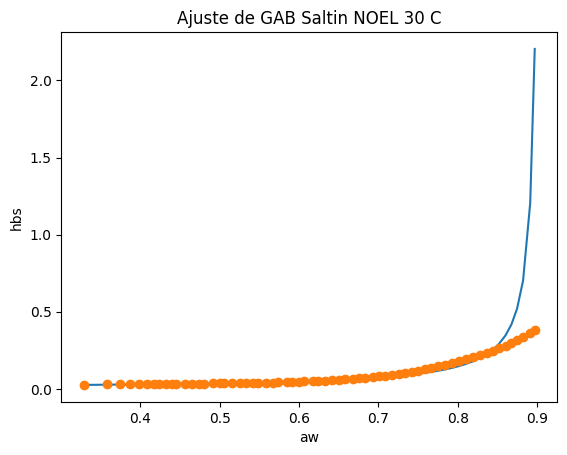

In [ ]:
#Fit awhbs Snack Tosh Queso y Albahaca NOEL 25.py
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 20 08:57:18 2016

@author: GNjabuiles
"""


from scipy.integrate import quad

## Función de Integración

def integrand(aw, K, Y1, awe):
    return (1+K**2*(Y1-1)*aw**2)/((awe-aw)*(1-K*aw+Y1*K*aw)**2)

## Definiendo Parámetros

import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import numpy as np
#import math



## Ingreso De Isotermas De Sorción Provenientes del VSA

## Vector de Actividad Acuosa

awex=np.array([0.3289,
0.3586,
0.3739,
0.3876,
0.3987,
0.4082,
0.417,
0.424,
0.4319,
0.4394,
0.4456,
0.4559,
0.4655,
0.4737,
0.4797,
0.4916,
0.5,
0.5057,
0.5153,
0.5251,
0.5328,
0.5426,
0.5488,
0.558,
0.5672,
0.5736,
0.5844,
0.591,
0.6003,
0.6066,
0.6177,
0.6239,
0.6332,
0.6412,
0.6508,
0.6581,
0.6678,
0.6752,
0.683,
0.6932,
0.7012,
0.7089,
0.7168,
0.7255,
0.7334,
0.7423,
0.7497,
0.7584,
0.7666,
0.775,
0.7838,
0.7933,
0.8018,
0.8107,
0.8194,
0.828,
0.8366,
0.8443,
0.8519,
0.8602,
0.8677,
0.8747,
0.8823,
0.8913,
0.897])



## Vector de Humedad En Base Seca

hbs=np.array([0.0276,
0.0289,
0.0293,
0.0298,
0.0304,
0.0313,
0.0311,
0.0313,
0.0315,
0.032,
0.0319,
0.033,
0.0337,
0.0337,
0.0341,
0.0349,
0.0357,
0.0356,
0.0366,
0.0372,
0.0376,
0.0389,
0.0393,
0.0399,
0.0411,
0.0426,
0.0441,
0.0449,
0.0466,
0.0479,
0.05,
0.0518,
0.0541,
0.056,
0.0587,
0.0612,
0.0647,
0.0681,
0.0714,
0.0759,
0.0801,
0.0846,
0.0895,
0.0959,
0.1021,
0.1095,
0.1172,
0.1259,
0.1355,
0.1456,
0.1569,
0.1684,
0.1806,
0.193,
0.2059,
0.2189,
0.2326,
0.2467,
0.2617,
0.278,
0.2955,
0.3145,
0.3358,
0.3598,
0.3816])




## Ajuste de Parámetros para Isoterma de GAB # No modificar
awhbs=awex/hbs

def fit_sim(x,awex,awhbs):
    a=x[0]  ##B
    b=x[1] ##C
    c=x[2] ##L

    #tio=np.linspace(0,120,50)
    return (awhbs-(a*awex**2+b*awex+c))


xcero = [1.0, 1.0, 1.0]


## FUnción de Optimización de parámetros ára ajuste de GAB

x,c,info,msg,success=leastsq(fit_sim,xcero,args=(awex,awhbs),full_output=1)

awhbs_new=x[0]*awex**2+x[1]*awex+x[2]
hbs_new=awex/awhbs_new

## Constantes de GAB

Mgm=np.sqrt(1/((x[1]**2)-4*x[0]*x[2]))
K=-1*((2*x[0]*Mgm)/(x[1]*Mgm+1))
Y1=1/(Mgm*x[2]*K)


## Constantes Ecuación Antoinne para Presión de Vapor en Función de T aplican entre 0 y 100 °C
A1=8.07131
B1=1730.63
C1=233.426

#Datos de Entrada Adicionales a la isoterma de sorciónn (Ingresa Usuario)

awi=0.1 # Actividad Acuosa Inicial del Producto
awc=0.55 # Actividad Acuosa Crítica
awe=0.68 #Humedad Relativa de almacenamiento expresado como proporciónj (%HR/100)
T=37.8 # Temperatura del Ensayo de WVTR usualmente es la misma en °C (NO TOCAR)
Ta=30 # Temperatura de Almacenamiento del Producto en °C
WVTR=0.267 ## Velocidad de Transmisión de Vapor de Agua en g/m^2*día. Lo determina el ICIPC (Eafit)
A=0.2541## Area empacada expuesta, corresponde con el área geompetrica de la unidad de venta en m^2
W= 156 ## Peso neto empacado en g


## Cálculos relacionados y Solución de Ecuación Diferencial

Po=10**(A1-(B1/(C1+T)))*(101325/760) #Presión de Vapor de Agua en el a T °C
P=10**(A1-(B1/(C1+Ta)))*(101325/760) #Presión de Vapor del agua a Ta °C
dhr=awe-awi ## Delta de humedad
B=WVTR/(Po*dhr) # Permabilidad del material de empaque

tg=(B*A*P)/(Mgm*Y1*K*W) # Lado derecho ecuación diferencial
y = quad(integrand, awi, awc, args= (K, Y1,awe) ) ## Solución lado izquierdo ecuación diferencial
t=y[0]/tg # tiempo de vida útil en días

## Impresión de Mensaje con el resultado de predicción en días

cadena= "El tiempo de Vida Útil para su producto" + " almacenado a " + str(Ta) + " °C" + " y " + str(awe*100) +" %" " es: " + str(round(t,2)) + " dias"
print(cadena)

## Gráficos relacionados

plt.plot(awex,hbs_new,awex,hbs,'o')
plt.title('Ajuste de GAB Saltin NOEL 30 C')
plt.ylabel('hbs')
plt.xlabel('aw')